# Bounds on the Secrecy Outage Probability

## No CSI-T

Add more information about this...

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

In [2]:
from bounds_no_csit import lower_bound_no_csit, upper_bound_no_csit, independent_no_csit

In [3]:
def plot_no_csit_bounds():
    snr_db = np.arange(-5, 16, 0.5)
    snr_bob = 10**(snr_db/10)
    curves = {"lower": lower_bound_no_csit,
              "upper": upper_bound_no_csit,
              "indep": independent_no_csit}
    fig, ax = plt.subplots()
    plots = {k: ax.semilogy(snr_db, np.ones(len(snr_db)))[0] for k in curves.keys()}
    ax.set_xlabel("SNR [dB]")
    ax.set_ylabel("Outage Probability")
    ax.set_ylim([0.01, 1.1])
    def update_plot(snr_eve_db, r_s, r_c, lam_x, lam_y):
        snr_eve = 10**(snr_eve_db/10)
        lam_xt = lam_x/snr_bob
        lam_yt = lam_y/(snr_eve*2**r_s)
        for _name, _func in curves.items():
            plots[_name].set_ydata(_func(r_s, r_c, lam_xt, lam_yt))
    interact(update_plot, snr_eve_db=(-5, 5), r_s=(0.01, 2, 0.01), r_c=(0.01, 2, 0.01),
             lam_x=(0.01, 3, 0.03), lam_y=(0.01, 3, 0.03))
    plt.show()

<IPython.core.display.Javascript object>


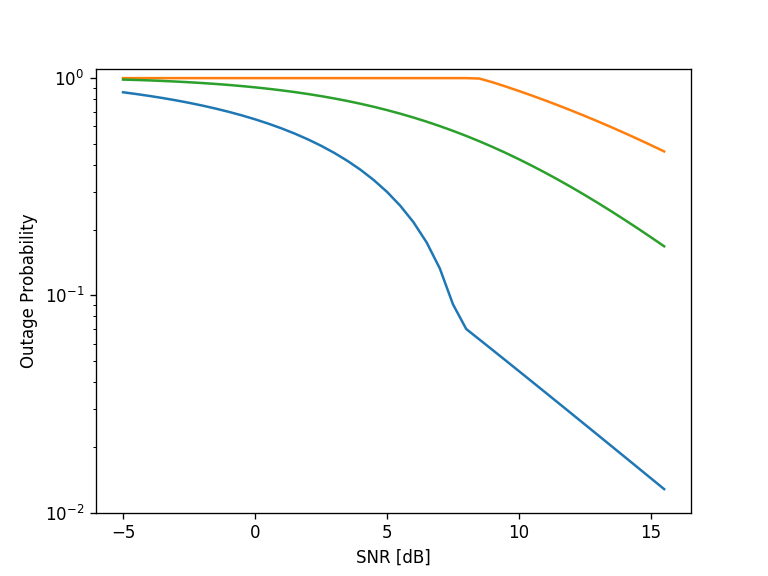

interactive(children=(IntSlider(value=0, description='snr_eve_db', max=5, min=-5), FloatSlider(value=1.0, desc…

In [18]:
plot_no_csit_bounds()

In [5]:
import numpy as np
from scipy import optimize
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

In [6]:
def cdf_x(x, lam=1):
    return np.maximum(1.-np.exp(-x*lam), 0)

def cdf_y(y, lam=1):
    return np.minimum(np.exp(y*lam), 1)

def cdf_x_minus_y_ind(z, lam_x=1, lam_y=1):
    return (np.exp(-lam_x*z)*(-lam_y + np.exp(lam_x*z)*lam_y + np.exp(lam_x*z)*lam_x))/(lam_y + lam_x)
    #return np.piecewise(z, [z < 0, z >= 0], [lambda d: (np.exp(lam_y*d)*lam_x)/(lam_x + lam_y),
    #                                         lambda d: (np.exp(-lam_x*d)*(-lam_y + np.exp(lam_x*d)*lam_y + np.exp(lam_x*d)*lam_x))/(lam_y + lam_x)])

def w_copula(a, b, **kwargs):
    return np.maximum(a + b - 1, 0)

def m_copula(a, b, **kwargs):
    return np.minimum(a, b)

def prod_copula(a, b, **kwargs):
    return a*b

In [7]:
def eps_a(r_s, r_c, lam_x=1, snr_bob=1):
    lam_x_tilde = lam_x/snr_bob
    return cdf_x(2**(r_s+r_c)-1, lam=lam_x_tilde)

def eps_b(r_s, r_c, lam_y=1, snr_eve=1):
    lam_y_tilde = lam_y/(2**r_s*snr_eve)
    return cdf_y(2**r_s-2**(r_s+r_c), lam=lam_y_tilde)

def eps_c(r_s, r_c, lam_x=1, lam_y=1, snr_bob=1, snr_eve=1, copula="ind"):
    if copula != "ind":
        raise NotImplementedError
    lam_x_tilde = lam_x/snr_bob
    lam_y_tilde = lam_y/(2**r_s*snr_eve)
    return cdf_x_minus_y_ind(2**r_s-1, lam_x_tilde, lam_y_tilde)

In [8]:
def eps_joint(r_s, r_c, lam_x=1, lam_y=1, snr_bob=1, snr_eve=1, copula="low"):
    if copula.startswith("up"):
        copula = w_copula
    elif copula.startswith("low"):
        copula = m_copula
    elif copula.startswith("ind"):
        copula = prod_copula
    else:
        raise NotImplementedError()
    alpha = 2**(r_s+r_c)-1
    beta = 2**r_s-2**(r_s+r_c)
    lam_x_tilde = lam_x/snr_bob
    lam_y_tilde = lam_y/(2**r_s*snr_eve)
    f_xt = cdf_x(alpha, lam=lam_x_tilde)
    f_yt = cdf_y(beta, lam=lam_y_tilde)
    return copula(f_xt, f_yt)

In [9]:
def plot_bounds_3d():
    snr_db = np.arange(-5, 11, .5)
    RX, RY = np.meshgrid(snr_db, snr_db)
    snr_lin_bob = 10**(RX/10)
    snr_lin_eve = 10**(RY/10)
    lam_x = 1
    lam_y = 1
    r_s = .2
    r_c = .5
    e_a = eps_a(r_s, r_c, lam_x=lam_x, snr_bob=snr_lin_bob)
    e_b = eps_b(r_s, r_c, lam_y=lam_y, snr_eve=snr_lin_eve)
    fig, ax = plt.subplots(1,1, subplot_kw={"projection": "3d"})
    for bound in ['low', 'up', 'ind']:
        e_joint = eps_joint(r_s, r_c, lam_x=lam_x, lam_y=lam_y, 
                            snr_bob=snr_lin_bob, snr_eve=snr_lin_eve, 
                            copula=bound)
        eps = e_a + e_b - e_joint
        surf = ax.plot_surface(RX, RY, eps, label=bound, alpha=.5)
        surf._facecolors2d = surf._facecolors3d
        surf._edgecolors2d = surf._edgecolors3d #https://github.com/matplotlib/matplotlib/issues/4067
        #ax.semilogy(RX, RY, eps, label=bound)
    ax.set_xlabel("SNR Bob")
    ax.set_ylabel("SNR Eve")
    ax.set_zlabel("Eps")
    ax.set_zscale('log')
    ax.legend()

<IPython.core.display.Javascript object>


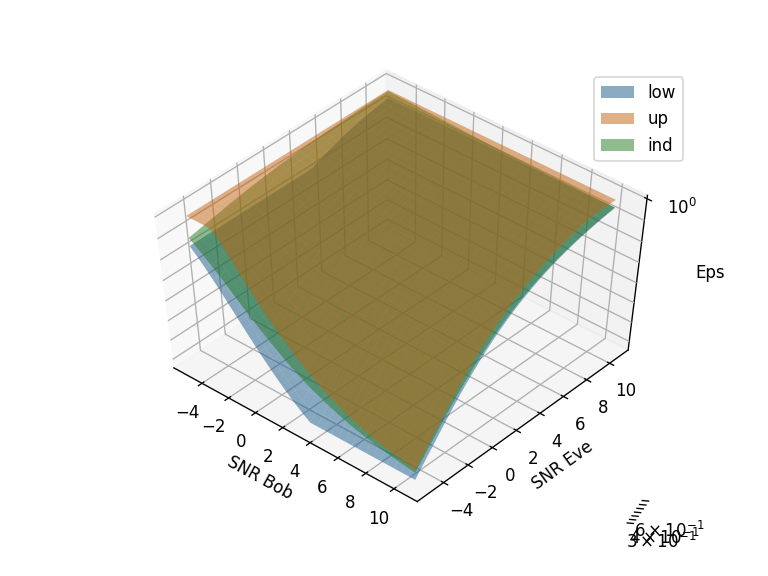

In [10]:
plot_bounds_3d()

In [11]:
def plot_bounds():
    snr_db = np.arange(-5, 11, .5)
    snr_lin = 10**(snr_db/10)
    snr_lin_eve = snr_lin
    #snr_lin_eve = 10**(5/10)*np.ones(*np.shape(snr_lin))
    fig, ax = plt.subplots()
    def update_plot(lam_x, lam_y, r_s, r_c):
        ax.clear()
        ax.set_xlabel("SNR [dB]")
        ax.set_ylabel("Outage Probability")
        ax.set_ylim([1e-3, 1.05])
        e_a = eps_a(r_s, r_c, lam_x=lam_x, snr_bob=snr_lin)
        e_b = eps_b(r_s, r_c, lam_y=lam_y, snr_eve=snr_lin_eve)
        e_c_ind = eps_c(r_s, r_c, lam_x=lam_x, lam_y=lam_y, 
                        snr_bob=snr_lin, snr_eve=snr_lin_eve, 
                        copula="ind")
        ax.semilogy(snr_db, e_a, label="Event 1")
        ax.semilogy(snr_db, e_b, label="Event 2")
        ax.semilogy(snr_db, e_b, label="Event 2")
        #for bound in ['low', 'up', 'ind']:
        #    e_joint = eps_joint(r_s, r_c, lam_x=lam_x, lam_y=lam_y, 
        #                        snr_bob=snr_lin, snr_eve=snr_lin_eve, 
        #                        copula=bound)
        #    eps = e_a + e_b - e_joint
        #    ax.semilogy(snr_db, eps, label=bound)
        ax.legend()
    interact(update_plot, lam_x=(.01, 1, .1), lam_y=(.5, 2, .1), r_s=(.01, 2, .05), r_c=(.01, 2, .05))

<IPython.core.display.Javascript object>


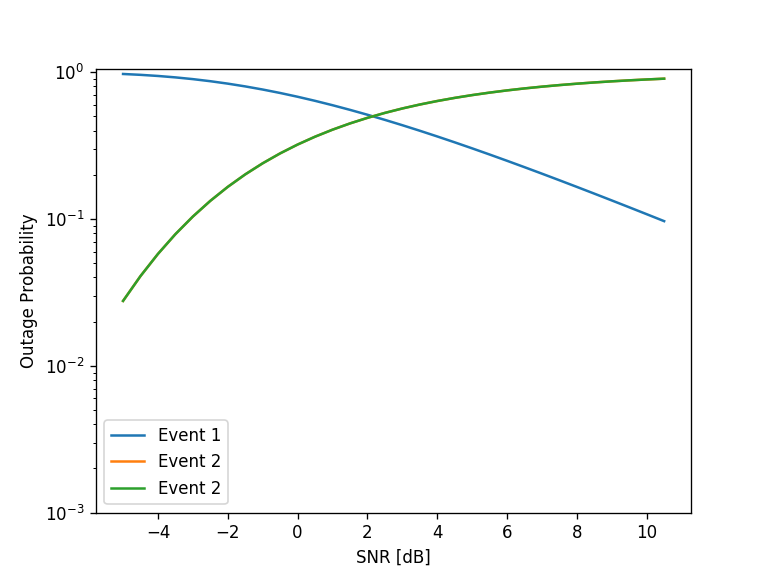

interactive(children=(FloatSlider(value=0.41000000000000003, description='lam_x', max=1.0, min=0.01), FloatSli…

In [12]:
plot_bounds()

In [13]:
def plot_over_rates():
    r_c = np.linspace(0.01, 2)
    fig, ax = plt.subplots()
    def update_plot(lam_x, lam_y, r_s, snr_bob, snr_eve):
        ax.clear()
        ax.set_xlabel("$R_C$")
        ax.set_ylabel("Outage Probability")
        snr_lin_bob = 10**(snr_bob/10)
        snr_lin_eve = 10**(snr_eve/10)
        #ax.set_ylim([-.05, 1.05])
        e_a = eps_a(r_s, r_c, lam_x=lam_x, snr_bob=snr_lin_bob)
        e_b = eps_b(r_s, r_c, lam_y=lam_y, snr_eve=snr_lin_eve)
        ax.semilogy(r_c, e_a, label="Event 1")
        ax.semilogy(r_c, e_b, label="Event 2")
        #for bound in ['low', 'up', 'ind']:
        #    e_joint = eps_joint(r_s, r_c, lam_x=lam_x, lam_y=lam_y, 
        #                        snr_bob=snr_lin_bob, snr_eve=snr_lin_eve, 
        #                        copula=bound)
        #    eps = e_a + e_b - e_joint
        #    ax.semilogy(r_c, eps, label=bound)
        ax.legend()
    interact(update_plot, lam_x=(.5, 2, .1), lam_y=(.5, 2, .1), r_s=(.01, 2, .05), snr_bob=(-5, 10, 1), snr_eve=(-5, 10, 1))

<IPython.core.display.Javascript object>


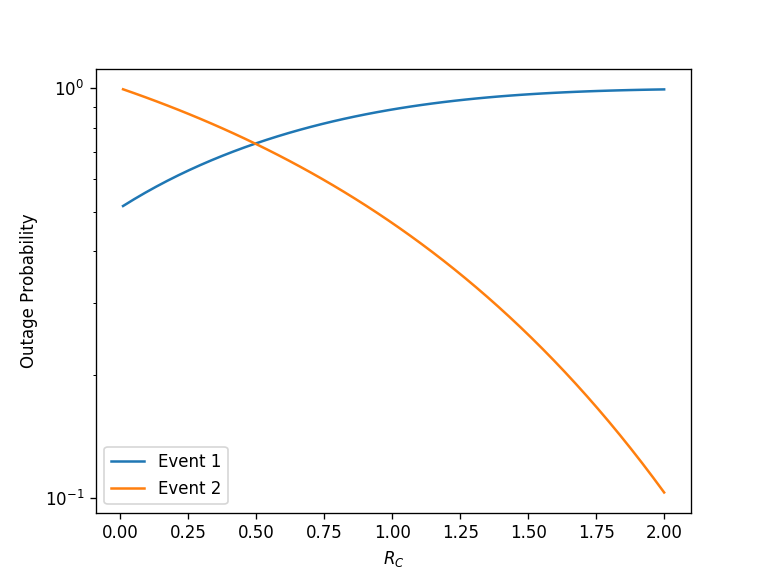

interactive(children=(FloatSlider(value=1.2000000000000002, description='lam_x', max=2.0, min=0.5), FloatSlide…

In [14]:
plot_over_rates()

In [15]:
from scipy import stats
lambda_x = .5
lambda_y = 2
snr_db = np.arange(-5, 11)
snr_lin = 10**(snr_db/10)
X = stats.expon.rvs(scale=1/lambda_x, size=int(1e5))
Y = stats.expon.rvs(scale=1/lambda_y, size=int(1e5))

In [16]:
rb = np.array([np.log2(1 + snr*X) for snr in snr_lin])
re = np.array([np.log2(1 + snr*Y) for snr in snr_lin])

<IPython.core.display.Javascript object>


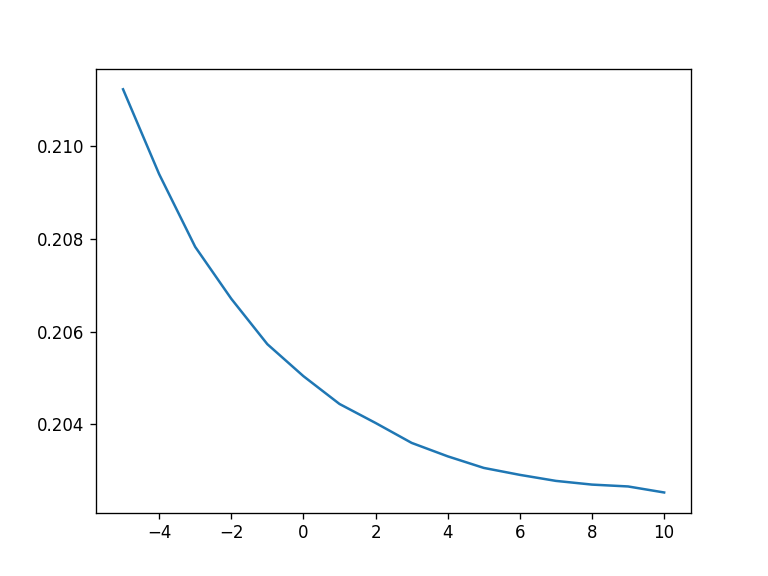

In [17]:
outage = np.count_nonzero(rb - re < 0.01, axis=1)/1e5
fig, ax = plt.subplots()
ax.plot(snr_db, outage)